In [65]:
import pandas as pd
import numpy as np

from utilities.preprocessors import preprocess, assign_gender, series_to_1D_array, map_value_to_index
from utilities.visualizers import view_rows, view_all_splits_results, ModelResults
from utilities.loaders import load_file, load_meta_data, load_model, save_meta_data, save_lookup_array
from models.fil_lstm_glove import load_lstm_model

import os
import re

from dotenv import load_dotenv
from pathlib import Path

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataframe

In [2]:
conn_info = pd.read_csv('../documents/conn_info.csv', index_col=0)
conn_info

,email,mobile_no,company_name,conn_link,conn_name,gender,salutation
0,paulinomarcus2914@gmail.com,0,Dyson · Full-time,https://www.linkedin.com/in/paulinomarcus/,Marcus Paulino,male,NaN
1,jhericksid15@gmail.com,09294383786 (Home),Cielo Talent · Full-time,https://www.linkedin.com/in/jhericksid/,Jherick Sid Celestial,male,NaN
2,EvanJake.Montano@libertymutual.com,+639260328119 (Mobile),Tata Consultancy Services · Full-time,https://www.linkedin.com/in/evanjakesorianomon...,Evan Jake Soriano Montano,male,NaN
3,capiorheg@gmail.com,0,JBW Managed Services and Consulting Corp · Ful...,https://www.linkedin.com/in/reggielee-capio-a4...,Reggielee Capio,male,NaN
4,johncarlotadeo18@gmail.com,+639432681245 (Mobile),Trojan Recruitment Group · Full-time,https://www.linkedin.com/in/john-carlo-tadeo-2...,John Carlo Tadeo,male,NaN
...,...,...,...,...,...,...,...
1065,NaN,0,transcosmos Asia Philippines Inc. · Full-time,https://www.linkedin.com/in/jamie-rose-cleofas...,Jamie Rose Cleofas,NaN,NaN
1066,jovitfrias@gmail.com,0,RCM Health Care Services · Full-time,https://www.linkedin.com/in/jovit-frias-06a561...,Jovit Frias,NaN,NaN
1067,danlopezatwork@gmail.com,0,Abacus Service Corporation · Full-time,https://www.linkedin.com/in/danlopezprofessional/,Mark Daniel Lopez,NaN,NaN
1068,dmrc_06@yahoo.com,09983696222 (Mobile),RingCentral · Full-time,https://www.linkedin.com/in/daena-michaela-roy...,Daena Michaela Ceria,NaN,NaN


In [3]:
conn_info['gender'].unique()

array(['male', 'female', nan], dtype=object)

In [4]:
# what I want to do is if there are names that have more than 1 first name e.g.
# Jherick and Sid, we want to train a classifier that classifies these individual
# names and output its probability and then average these two probabilities to get
# the final probability of whether it is male or female name
# i.e. Jherick has prob 0.75732 of being positive label Sid has prob of 0.6343 of
# being a positive label the average of this would be 0.69581 which would be a postive
# label, wee can assign the positive label 1 to a male label and the negative label 0
# would be female
conn_info['conn_name'].apply(lambda name: name.split() if not pd.isna(name) else name)

0                    [Marcus, Paulino]
1            [Jherick, Sid, Celestial]
2       [Evan, Jake, Soriano, Montano]
3                   [Reggielee, Capio]
4                 [John, Carlo, Tadeo]
                     ...              
1065            [Jamie, Rose, Cleofas]
1066                    [Jovit, Frias]
1067             [Mark, Daniel, Lopez]
1068          [Daena, Michaela, Ceria]
1069              [Joana, Mace, Reyes]
Name: conn_name, Length: 1070, dtype: object

# Loading libraries for gender classifier

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import Dice, BinaryCrossentropy as bce_loss
from tensorflow.keras.metrics import BinaryAccuracy, BinaryCrossentropy as bce_metric, F1Score, AUC, Precision, Recall
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading dataset for gender classifier

In [6]:
name_gender_df = pd.read_csv('./data/name_gender_dataset.csv')
name_gender_df

,Name,Gender,Count,Probability
0,James,M,5304407,1.451679e-02
1,John,M,5260831,1.439753e-02
2,Robert,M,4970386,1.360266e-02
3,Michael,M,4579950,1.253414e-02
4,William,M,4226608,1.156713e-02
...,...,...,...,...
147264,Zylenn,M,1,2.736740e-09
147265,Zymeon,M,1,2.736740e-09
147266,Zyndel,M,1,2.736740e-09
147267,Zyshan,M,1,2.736740e-09


In [7]:
name_gender_df['Gender'].value_counts()

Gender
F    89749
M    57520
Name: count, dtype: int64

#### 0 for male 1 for female

In [8]:
name_gender_df['Gender'] = name_gender_df['Gender'].apply(lambda label: 0 if label == 'M' else 1)
name_gender_df['Gender'].value_counts()

Gender
1    89749
0    57520
Name: count, dtype: int64

In [9]:
name_gender_df["Name"] = name_gender_df["Name"].apply(lambda name: name.lower())
name_gender_df

,Name,Gender,Count,Probability
0,james,0,5304407,1.451679e-02
1,john,0,5260831,1.439753e-02
2,robert,0,4970386,1.360266e-02
3,michael,0,4579950,1.253414e-02
4,william,0,4226608,1.156713e-02
...,...,...,...,...
147264,zylenn,0,1,2.736740e-09
147265,zymeon,0,1,2.736740e-09
147266,zyndel,0,1,2.736740e-09
147267,zyshan,0,1,2.736740e-09


In [10]:
def helper(row):
    # splits the name into smaller chunks if the name
    # is more than 1
    
    name = row["Name"]
    gender = row["Gender"]

    new_name = re.sub(r'[^0-9A-Za-z]', " ", name)
    split_name = new_name.split(' ')
    if len(split_name) > 1:
        return [(name_chunk, gender) for name_chunk in split_name]
    
    return [(name, gender)]

In [11]:
name_gender_exp = name_gender_df.apply(helper, axis=1).to_list()
name_gender_exp

[[('james', 0)],
 [('john', 0)],
 [('robert', 0)],
 [('michael', 0)],
 [('william', 0)],
 [('mary', 1)],
 [('david', 0)],
 [('joseph', 0)],
 [('richard', 0)],
 [('charles', 0)],
 [('thomas', 0)],
 [('christopher', 0)],
 [('daniel', 0)],
 [('matthew', 0)],
 [('elizabeth', 1)],
 [('patricia', 1)],
 [('jennifer', 1)],
 [('anthony', 0)],
 [('george', 0)],
 [('linda', 1)],
 [('barbara', 1)],
 [('donald', 0)],
 [('paul', 0)],
 [('mark', 0)],
 [('andrew', 0)],
 [('steven', 0)],
 [('kenneth', 0)],
 [('edward', 0)],
 [('joshua', 0)],
 [('margaret', 1)],
 [('brian', 0)],
 [('kevin', 0)],
 [('jessica', 1)],
 [('sarah', 1)],
 [('susan', 1)],
 [('timothy', 0)],
 [('dorothy', 1)],
 [('jason', 0)],
 [('ronald', 0)],
 [('helen', 1)],
 [('ryan', 0)],
 [('jeffrey', 0)],
 [('karen', 1)],
 [('nancy', 1)],
 [('betty', 1)],
 [('lisa', 1)],
 [('jacob', 0)],
 [('nicholas', 0)],
 [('ashley', 1)],
 [('eric', 0)],
 [('frank', 0)],
 [('gary', 0)],
 [('anna', 1)],
 [('stephen', 0)],
 [('jonathan', 0)],
 [('sandra'

In [12]:
name_gender_exp_flat = series_to_1D_array(name_gender_exp)
name_gender_exp_flat

[('james', 0),
 ('john', 0),
 ('robert', 0),
 ('michael', 0),
 ('william', 0),
 ('mary', 1),
 ('david', 0),
 ('joseph', 0),
 ('richard', 0),
 ('charles', 0),
 ('thomas', 0),
 ('christopher', 0),
 ('daniel', 0),
 ('matthew', 0),
 ('elizabeth', 1),
 ('patricia', 1),
 ('jennifer', 1),
 ('anthony', 0),
 ('george', 0),
 ('linda', 1),
 ('barbara', 1),
 ('donald', 0),
 ('paul', 0),
 ('mark', 0),
 ('andrew', 0),
 ('steven', 0),
 ('kenneth', 0),
 ('edward', 0),
 ('joshua', 0),
 ('margaret', 1),
 ('brian', 0),
 ('kevin', 0),
 ('jessica', 1),
 ('sarah', 1),
 ('susan', 1),
 ('timothy', 0),
 ('dorothy', 1),
 ('jason', 0),
 ('ronald', 0),
 ('helen', 1),
 ('ryan', 0),
 ('jeffrey', 0),
 ('karen', 1),
 ('nancy', 1),
 ('betty', 1),
 ('lisa', 1),
 ('jacob', 0),
 ('nicholas', 0),
 ('ashley', 1),
 ('eric', 0),
 ('frank', 0),
 ('gary', 0),
 ('anna', 1),
 ('stephen', 0),
 ('jonathan', 0),
 ('sandra', 1),
 ('emily', 1),
 ('amanda', 1),
 ('kimberly', 1),
 ('michelle', 1),
 ('donna', 1),
 ('justin', 0),
 ('laur

#### Checking if there are still rows/names with '-' char

In [13]:
list(filter(lambda row: '-' in row[0], name_gender_exp))[:20]

[]

#### checking if there are still items in the `name_gender_exp_flat` that are lists

In [14]:
list(filter(lambda item: len(item) > 1, name_gender_exp))[:20]

[[('jo', 1), ('anne', 1)],
 [('jo', 1), ('ann', 1)],
 [('anne', 1), ('marie', 1)],
 [('zo', 1), ('', 1)],
 [('lee', 1), ('anne', 1)],
 [('lee', 1), ('ann', 1)],
 [('smt', 1), ('', 1)],
 [('ann', 1), ('marie', 1)],
 [('chlo', 1), ('', 1)],
 [('julie', 1), ('anne', 1)],
 [('mary', 1), ('ann', 1)],
 [('julie', 1), ('ann', 1)],
 [('am', 1), ('lie', 1)],
 [('lori', 1), ('ann', 1)],
 [('d', 0), ('arcy', 0)],
 [('mary', 1), ('anne', 1)],
 [('ma', 1), ('lle', 1)],
 [('emma', 1), ('lee', 1)],
 [('sarah', 1), ('jane', 1)],
 [('anna', 1), ('marie', 1)]]

In [15]:
list(filter(lambda item: type(item) == list, name_gender_exp_flat))[:20]

[]

In [16]:
name_gender_exp_flat

[('james', 0),
 ('john', 0),
 ('robert', 0),
 ('michael', 0),
 ('william', 0),
 ('mary', 1),
 ('david', 0),
 ('joseph', 0),
 ('richard', 0),
 ('charles', 0),
 ('thomas', 0),
 ('christopher', 0),
 ('daniel', 0),
 ('matthew', 0),
 ('elizabeth', 1),
 ('patricia', 1),
 ('jennifer', 1),
 ('anthony', 0),
 ('george', 0),
 ('linda', 1),
 ('barbara', 1),
 ('donald', 0),
 ('paul', 0),
 ('mark', 0),
 ('andrew', 0),
 ('steven', 0),
 ('kenneth', 0),
 ('edward', 0),
 ('joshua', 0),
 ('margaret', 1),
 ('brian', 0),
 ('kevin', 0),
 ('jessica', 1),
 ('sarah', 1),
 ('susan', 1),
 ('timothy', 0),
 ('dorothy', 1),
 ('jason', 0),
 ('ronald', 0),
 ('helen', 1),
 ('ryan', 0),
 ('jeffrey', 0),
 ('karen', 1),
 ('nancy', 1),
 ('betty', 1),
 ('lisa', 1),
 ('jacob', 0),
 ('nicholas', 0),
 ('ashley', 1),
 ('eric', 0),
 ('frank', 0),
 ('gary', 0),
 ('anna', 1),
 ('stephen', 0),
 ('jonathan', 0),
 ('sandra', 1),
 ('emily', 1),
 ('amanda', 1),
 ('kimberly', 1),
 ('michelle', 1),
 ('donna', 1),
 ('justin', 0),
 ('laur

In [17]:
names, genders = list(zip(*name_gender_exp_flat))
names

('james',
 'john',
 'robert',
 'michael',
 'william',
 'mary',
 'david',
 'joseph',
 'richard',
 'charles',
 'thomas',
 'christopher',
 'daniel',
 'matthew',
 'elizabeth',
 'patricia',
 'jennifer',
 'anthony',
 'george',
 'linda',
 'barbara',
 'donald',
 'paul',
 'mark',
 'andrew',
 'steven',
 'kenneth',
 'edward',
 'joshua',
 'margaret',
 'brian',
 'kevin',
 'jessica',
 'sarah',
 'susan',
 'timothy',
 'dorothy',
 'jason',
 'ronald',
 'helen',
 'ryan',
 'jeffrey',
 'karen',
 'nancy',
 'betty',
 'lisa',
 'jacob',
 'nicholas',
 'ashley',
 'eric',
 'frank',
 'gary',
 'anna',
 'stephen',
 'jonathan',
 'sandra',
 'emily',
 'amanda',
 'kimberly',
 'michelle',
 'donna',
 'justin',
 'laura',
 'ruth',
 'carol',
 'brandon',
 'larry',
 'scott',
 'melissa',
 'stephanie',
 'benjamin',
 'raymond',
 'samuel',
 'rebecca',
 'deborah',
 'gregory',
 'sharon',
 'kathleen',
 'amy',
 'cynthia',
 'alexander',
 'patrick',
 'jack',
 'henry',
 'angela',
 'shirley',
 'emma',
 'catherine',
 'katherine',
 'virgini

In [18]:
new_name_gender_df = pd.DataFrame({'name': names, 'gender': genders})
new_name_gender_df

,name,gender
0,james,0
1,john,0
2,robert,0
3,michael,0
4,william,0
...,...,...
155125,zylenn,0
155126,zymeon,0
155127,zyndel,0
155128,zyshan,0


In [19]:
# split into training and testing
trains, tests = train_test_split(new_name_gender_df, test_size=0.2, random_state=0)
trains

,name,gender
58421,enrike,0
44132,karo,0
6768,donna,0
104257,taimani,1
38115,abrial,1
...,...,...
97639,braizlee,1
95939,quali,0
152315,shivji,0
117952,amy,1


#### dataset indicates a slight imbalance therefore it may be useful to use AUC and F1 as a metric rather than accuracy 

In [20]:
# what we should do is encode each name we have into a numerical value
unique_train_names = trains['name'].unique().tolist()
unique_train_names

['enrike',
 'karo',
 'donna',
 'taimani',
 'abrial',
 'etrulia',
 'mandria',
 'aciel',
 'nhial',
 'lavie',
 'shawnae',
 'pramil',
 'shaquon',
 'aitlin',
 'editha',
 'siohban',
 'atyanna',
 'izidor',
 'rossieanna',
 'sherwyn',
 'tays',
 'sienne',
 'radvin',
 'klea',
 'genene',
 'aarish',
 'tyia',
 'dyneshia',
 'imoghen',
 'briellen',
 'shaney',
 'nikylja',
 'jayne',
 'kathy',
 'taitoko',
 'tyler',
 'meera',
 'crystalmarie',
 'quilla',
 'azrya',
 'olisia',
 'aubriona',
 'cranstone',
 'atilla',
 'neddy',
 'attis',
 'reegen',
 'aleeka',
 'conya',
 'emir',
 'tana',
 'kashmir',
 'ayasha',
 'dejene',
 'brianna',
 'shakida',
 'marie',
 'jhared',
 'jaiquez',
 'saelah',
 'dao',
 'gillard',
 'ammaar',
 'leonor',
 'evelynrose',
 'garnet',
 'jeffrey',
 'herodotus',
 'markya',
 'henrick',
 'iniyan',
 'greysyn',
 'naufahu',
 'arliene',
 'deryon',
 'vear',
 'trella',
 'milei',
 'jamine',
 'majok',
 'wilmar',
 'heysam',
 'antares',
 'lourena',
 'odell',
 'glentyn',
 'musfirah',
 'neiva',
 'loreley',
 '

In [21]:
# what we should do is encode each name we have into a numerical value
unique_test_names = tests['name'].unique().tolist()
unique_test_names

['monique',
 'brishae',
 'jaimison',
 'labasse',
 'neilina',
 'linda',
 'fakir',
 'syriah',
 'leigh',
 'samela',
 'jatziry',
 'kirstie',
 'teeya',
 'waverly',
 'kedrian',
 'haq',
 'comekia',
 'juanne',
 'juniel',
 'deshna',
 'dilynn',
 'harce',
 'jurij',
 'allan',
 'kahle',
 'azemara',
 'brasia',
 'navi',
 'tobey',
 'weslie',
 'mandi',
 'dataar',
 'sherrica',
 'ayudia',
 'dimitris',
 'pasqualine',
 'malika',
 'mary',
 'luie',
 'sanaii',
 'phillipos',
 'cynai',
 'caileen',
 'tracy',
 'jenniya',
 'seta',
 'jakailyn',
 'elverta',
 'may',
 'jaecyon',
 'jackaline',
 'tamina',
 'bernadeth',
 'antigone',
 'caua',
 'rhodney',
 'grosvenor',
 'keili',
 'ayoob',
 'mesut',
 'mckeyla',
 'kiera',
 'trome',
 'brienne',
 'jabree',
 'charndy',
 'ellisen',
 'jeromey',
 'annesha',
 'analysse',
 'kiaash',
 'maria',
 'nishanth',
 'khusbhoo',
 'amandarose',
 'amanie',
 'dejanai',
 'carya',
 'khalial',
 'aelianna',
 'basra',
 'armetha',
 'tennell',
 'leara',
 'johnbenedict',
 'neana',
 'hansraj',
 'jamaria',

In [22]:
# before joining again get array in df with longest length first
name_with_max = max(unique_train_names, key=len)
name_with_max

'polyentolyekmongtainh'

In [23]:
train_max_len = len(name_with_max)
train_max_len

21

In [24]:
num_unique_train_names = len(unique_train_names)
num_unique_train_names

104133

In [25]:
num_unique_test_names = len(unique_test_names)
num_unique_test_names

28467

In [26]:
chars, counts = np.unique(series_to_1D_array(trains['name']), return_counts=True)
chars

array(['0', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
       'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
       'y', 'z'], dtype='<U1')

In [27]:
counts

array([     5,      1, 132036,  10235,  16158,  23618,  86492,   4017,
         8368,  34523,  67789,  13292,  18557,  50257,  24788,  70348,
        31672,   5332,   2100,  52198,  36766,  29576,  16261,   9096,
         4236,   1587,  29658,   6837])

#### mapping each character to their respective indeces

In [ ]:

chars.tolist()

['0',
 '8',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [66]:
save_dir = f'./saved/misc/'
os.makedirs(save_dir, exist_ok=True)

file_path = os.path.join(save_dir, 'fil_name_gender_lstm_lookup.txt')
save_lookup_array(file_path, chars.tolist())

In [28]:
char_to_idx = map_value_to_index(chars)
idx_to_char = map_value_to_index(chars, inverted=True)

In [29]:
char_to_idx('a')

<tf.Tensor: shape=(), dtype=int64, numpy=3>

In [30]:
char_to_idx('b')

<tf.Tensor: shape=(), dtype=int64, numpy=4>

#### Unknown or 'UNK' characters are mapped to 0


In [31]:
char_to_idx('#').numpy().tolist()

0

In [32]:
trains["seqs"] = trains['name'].apply(lambda name: [char_to_idx(char).numpy().tolist() for char in name])
trains

,name,gender,seqs
58421,enrike,0,"[7, 16, 20, 11, 13, 7]"
44132,karo,0,"[13, 3, 20, 17]"
6768,donna,0,"[6, 17, 16, 16, 3]"
104257,taimani,1,"[22, 3, 11, 15, 3, 16, 11]"
38115,abrial,1,"[3, 4, 20, 11, 3, 14]"
...,...,...,...
97639,braizlee,1,"[4, 20, 3, 11, 28, 14, 7, 7]"
95939,quali,0,"[19, 23, 3, 14, 11]"
152315,shivji,0,"[21, 10, 11, 24, 12, 11]"
117952,amy,1,"[3, 15, 27]"


In [33]:
# post means place padding of 0's on the tail or ending of the sequence
# and truncating removes the values of a sequence that is greater than the max length given
train_seqs_padded = pad_sequences(trains["seqs"], maxlen=train_max_len, padding='post', truncating='post')
train_seqs_padded

array([[ 7, 16, 20, ...,  0,  0,  0],
       [13,  3, 20, ...,  0,  0,  0],
       [ 6, 17, 16, ...,  0,  0,  0],
       ...,
       [21, 10, 11, ...,  0,  0,  0],
       [ 3, 15, 27, ...,  0,  0,  0],
       [ 6, 27, 14, ...,  0,  0,  0]], dtype=int32)

In [34]:
train_seqs_padded.shape

(124104, 21)

In [35]:
tests["seqs"] = tests['name'].apply(lambda name: [char_to_idx(char).numpy().tolist() for char in name])
tests

,name,gender,seqs
131064,monique,1,"[15, 17, 16, 11, 19, 23, 7]"
68142,brishae,1,"[4, 20, 11, 21, 10, 3, 7]"
76765,jaimison,0,"[12, 3, 11, 15, 11, 21, 17, 16]"
147582,labasse,0,"[14, 3, 4, 3, 21, 21, 7]"
102519,neilina,1,"[16, 7, 11, 14, 11, 16, 3]"
...,...,...,...
23922,maximilien,0,"[15, 3, 26, 11, 15, 11, 14, 11, 7, 16]"
137781,ann,1,"[3, 16, 16]"
100559,kathran,1,"[13, 3, 22, 10, 20, 3, 16]"
87645,courtnee,0,"[5, 17, 23, 20, 22, 16, 7, 7]"


In [36]:
# post means place padding of 0's on the tail or ending of the sequence
# and truncating removes the values of a sequence that is greater than the max length given
test_seqs_padded = pad_sequences(tests["seqs"], maxlen=train_max_len, padding='post', truncating='post')
test_seqs_padded

array([[15, 17, 16, ...,  0,  0,  0],
       [ 4, 20, 11, ...,  0,  0,  0],
       [12,  3, 11, ...,  0,  0,  0],
       ...,
       [13,  3, 22, ...,  0,  0,  0],
       [ 5, 17, 23, ...,  0,  0,  0],
       [18,  3, 20, ...,  0,  0,  0]], dtype=int32)

In [37]:
test_seqs_padded.shape

(31026, 21)

In [38]:
char_to_idx.get_vocabulary()

['[UNK]',
 np.str_('0'),
 np.str_('8'),
 np.str_('a'),
 np.str_('b'),
 np.str_('c'),
 np.str_('d'),
 np.str_('e'),
 np.str_('f'),
 np.str_('g'),
 np.str_('h'),
 np.str_('i'),
 np.str_('j'),
 np.str_('k'),
 np.str_('l'),
 np.str_('m'),
 np.str_('n'),
 np.str_('o'),
 np.str_('p'),
 np.str_('q'),
 np.str_('r'),
 np.str_('s'),
 np.str_('t'),
 np.str_('u'),
 np.str_('v'),
 np.str_('w'),
 np.str_('x'),
 np.str_('y'),
 np.str_('z')]

In [39]:
train_labels = trains["gender"].to_numpy().reshape(-1, 1)
test_labels = tests["gender"].to_numpy().reshape(-1, 1)

In [40]:
train_labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [41]:
test_labels.shape

(31026, 1)

In [44]:
# char_to_idx already includes oov words so no need for +1
vocab_len = len(char_to_idx.get_vocabulary())
# emb_dict, emb_vec_len = construct_embedding_dict('./embeddings/glove.twitter.27B.50d.txt', word_to_index)
# emb_matrix = construct_embedding_matrix(word_to_index, emb_dict, emb_vec_len)

hyper_params = {
    "input_shape": train_max_len, 
    "vocab_len": vocab_len,
    "emb_dim": 256,
    "emb_matrix": None,
    "n_a": 128,
    "rnn_drop_prob": 0.2,
    "dense_drop_prob": 0.2,
    "n_units": 1
}

# by default our max lenth is 21, vocab length of 29 (including UNK), and embedding dimension of 256
lstm_model = load_lstm_model(**hyper_params)

input shape: 21


In [45]:
# emb_matrix.shape

In [46]:
# emb_matrix.any(axis=1).sum()

In [47]:
lstm_model.summary()

Model: "fil-name-gender-lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding-layer (Embedding)     │ (None, 21, 256)        │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,921 (1.53 MB)

 Trainable params: 401,921 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
lstm_model.get_layer('embedding-layer').weights

[<KerasVariable shape=(29, 256), dtype=float32, path=fil-name-gender-lstm/embedding-layer/embeddings>]

In [49]:
train_seqs_padded

array([[ 7, 16, 20, ...,  0,  0,  0],
       [13,  3, 20, ...,  0,  0,  0],
       [ 6, 17, 16, ...,  0,  0,  0],
       ...,
       [21, 10, 11, ...,  0,  0,  0],
       [ 3, 15, 27, ...,  0,  0,  0],
       [ 6, 27, 14, ...,  0,  0,  0]], dtype=int32)

https://www.kaggle.com/code/shrikrishnaparab/gender-prediction-based-on-name-using-lstm

In [52]:
save_dir = f'./saved/misc/'
os.makedirs(save_dir, exist_ok=True)

hyper_params_path = os.path.join(save_dir, f'fil_name_gender_lstm_hyper_params.json')
save_meta_data(hyper_params_path, hyper_params)

In [53]:
# compile model
lstm_model.compile(
    # be careful with picking loss functions i.e. Dice loss as it can
    # interfere with model training, and can give the illusion that performance
    # metrics are not improving when they can improve if you just use the right
    # loss function
    loss=bce_loss(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[bce_metric(), BinaryAccuracy(), Precision(), Recall(), F1Score(), AUC()]
)

In [57]:
# create dir first
os.makedirs(f'./saved/weights/', exist_ok=True)

# define checkpoint and early stopping callback to save
# best weights at each epoch and to stop if there is no improvement
# of validation loss for 10 consecutive epochs
path = f"./saved/weights/fil_name_gender_lstm"
info = "_{epoch:02d}_{val_auc:.4f}.weights.keras"
weights_path = path + info

# create callbacks
checkpoint = ModelCheckpoint(
    weights_path,
    monitor='val_auc',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max')
stopper = EarlyStopping(
    monitor='val_auc',
    patience=10)
    
# append callbacks
callbacks = [checkpoint, stopper]

In [58]:
lstm_history = lstm_model.fit(
    train_seqs_padded, train_labels,
    batch_size=64,
    epochs=10,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/10
1551/1552 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8730 - binary_accuracy: 0.8010 - binary_crossentropy: 0.4326 - f1_score: 0.7614 - loss: 0.4326 - precision: 0.8357 - recall: 0.8417
Epoch 1: val_auc improved from -inf to 0.88020, saving model to ./saved/weights/fil_name_gender_lstm_01_0.8802.weights.keras
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - auc: 0.8730 - binary_accuracy: 0.8010 - binary_crossentropy: 0.4326 - f1_score: 0.7614 - loss: 0.4326 - precision: 0.8358 - recall: 0.8417 - val_auc: 0.8802 - val_binary_accuracy: 0.8085 - val_binary_crossentropy: 0.4217 - val_f1_score: 0.7607 - val_loss: 0.4217 - val_precision: 0.8466 - val_recall: 0.8403
Epoch 2/10
1551/1552 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8807 - binary_accuracy: 0.8078 - binary_crossentropy: 0.4203 - f1_score: 0.7623 - loss: 0.4203 - precision: 0.8429 - recall: 0.8456
Epoch 2: val_auc improved from 0.88020 to 0.88279, saving model to ./saved/weights/fil_name_gender_lstm_02_0.8828.weights.keras


In [59]:
lstm_results = lstm_history.history
lstm_results

{'auc': [0.8746405243873596,
  0.8812754154205322,
  0.8861483931541443,
  0.8905876874923706,
  0.8936259746551514,
  0.896675169467926,
  0.8992518186569214,
  0.9016092419624329,
  0.9037023782730103,
  0.9059439897537231],
 'binary_accuracy': [0.8025643825531006,
  0.80943363904953,
  0.8140769600868225,
  0.8181058168411255,
  0.8218728303909302,
  0.8250758051872253,
  0.8273823261260986,
  0.829265832901001,
  0.8310284614562988,
  0.8341508507728577],
 'binary_crossentropy': [0.4297926425933838,
  0.41929367184638977,
  0.411324679851532,
  0.4038277864456177,
  0.3985387682914734,
  0.39296600222587585,
  0.3885759711265564,
  0.3842535614967346,
  0.3804180324077606,
  0.3761031925678253],
 'f1_score': [0.7623351216316223,
  0.7623351216316223,
  0.7623351216316223,
  0.7623351216316223,
  0.7623351216316223,
  0.7623351216316223,
  0.7623351216316223,
  0.7623351216316223,
  0.7623351216316223,
  0.7623351216316223],
 'loss': [0.4297926425933838,
  0.41929367184638977,
  0.4

In [60]:
model_results = ModelResults(lstm_results, lstm_history.epoch, style="default")

loss
val_loss
{'loss': [0.4297926425933838, 0.41929367184638977, 0.411324679851532, 0.4038277864456177, 0.3985387682914734, 0.39296600222587585, 0.3885759711265564, 0.3842535614967346, 0.3804180324077606, 0.3761031925678253], 'val_loss': [0.4217173755168915, 0.41810256242752075, 0.41461682319641113, 0.4149954617023468, 0.4090218245983124, 0.40824010968208313, 0.40800389647483826, 0.4057598412036896, 0.4048004150390625, 0.4060958921909332]}


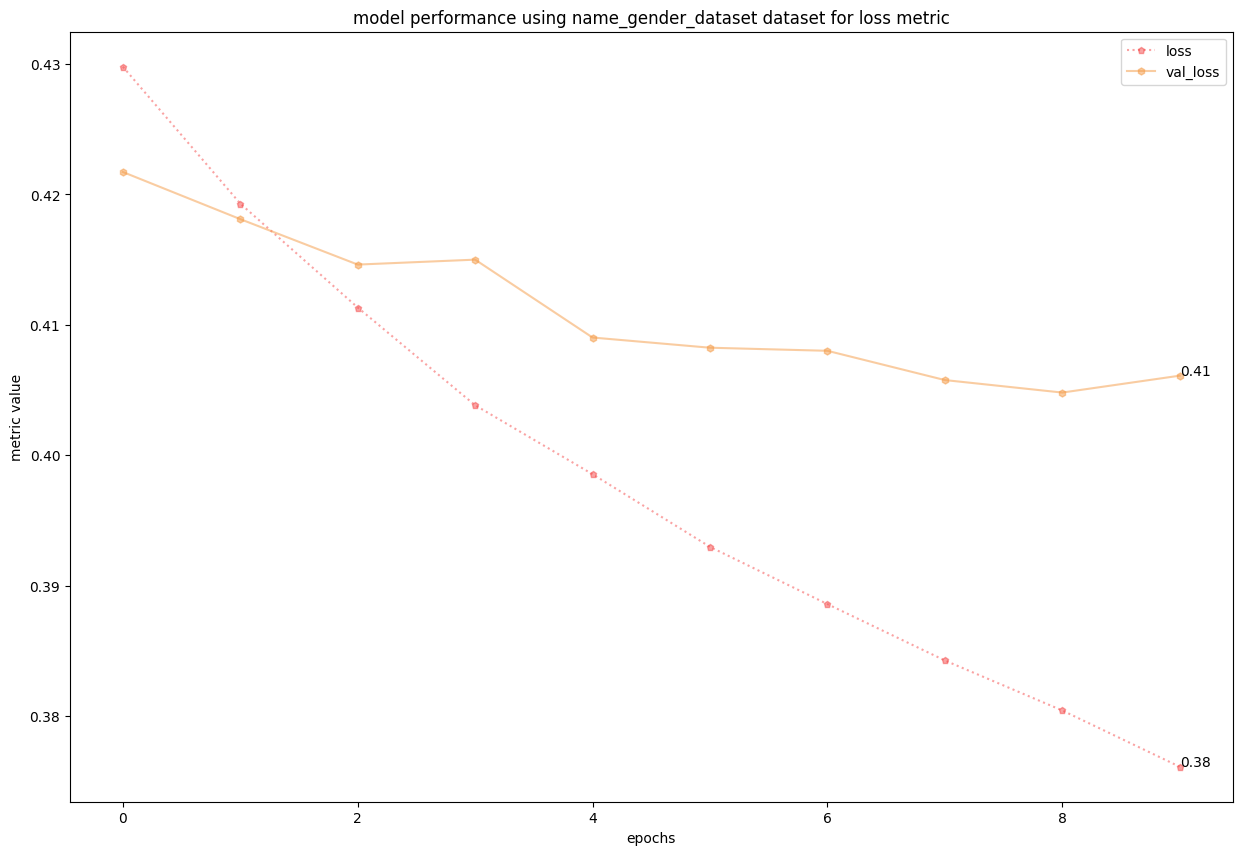

binary_crossentropy
val_binary_crossentropy
{'binary_crossentropy': [0.4297926425933838, 0.41929367184638977, 0.411324679851532, 0.4038277864456177, 0.3985387682914734, 0.39296600222587585, 0.3885759711265564, 0.3842535614967346, 0.3804180324077606, 0.3761031925678253], 'val_binary_crossentropy': [0.4217173755168915, 0.41810256242752075, 0.41461682319641113, 0.4149954617023468, 0.4090218245983124, 0.40824010968208313, 0.40800389647483826, 0.4057598412036896, 0.4048004150390625, 0.4060958921909332]}


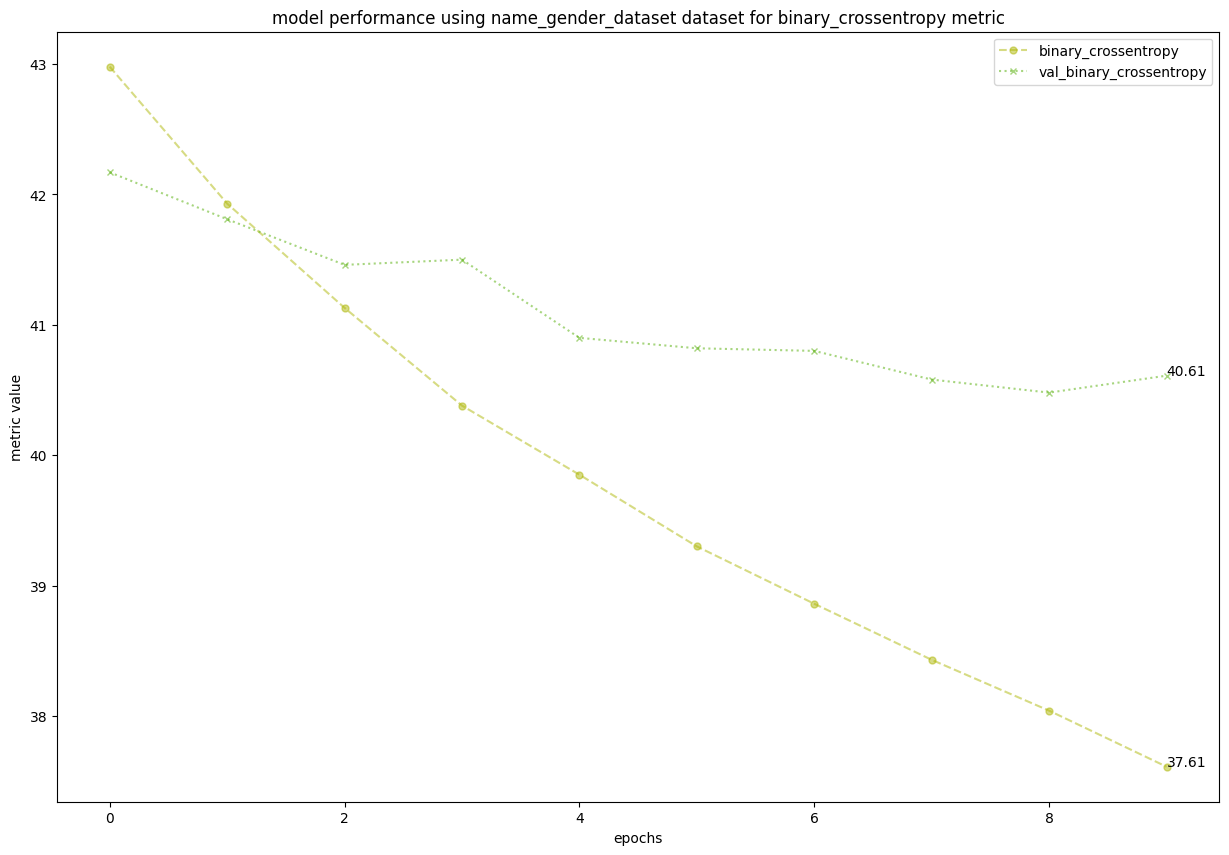

binary_accuracy
val_binary_accuracy
{'binary_accuracy': [0.8025643825531006, 0.80943363904953, 0.8140769600868225, 0.8181058168411255, 0.8218728303909302, 0.8250758051872253, 0.8273823261260986, 0.829265832901001, 0.8310284614562988, 0.8341508507728577], 'val_binary_accuracy': [0.8085089325904846, 0.810160756111145, 0.8107650876045227, 0.8119737505912781, 0.8144716024398804, 0.8151162266731262, 0.8155190944671631, 0.8164054751396179, 0.8170098066329956, 0.8178558349609375]}


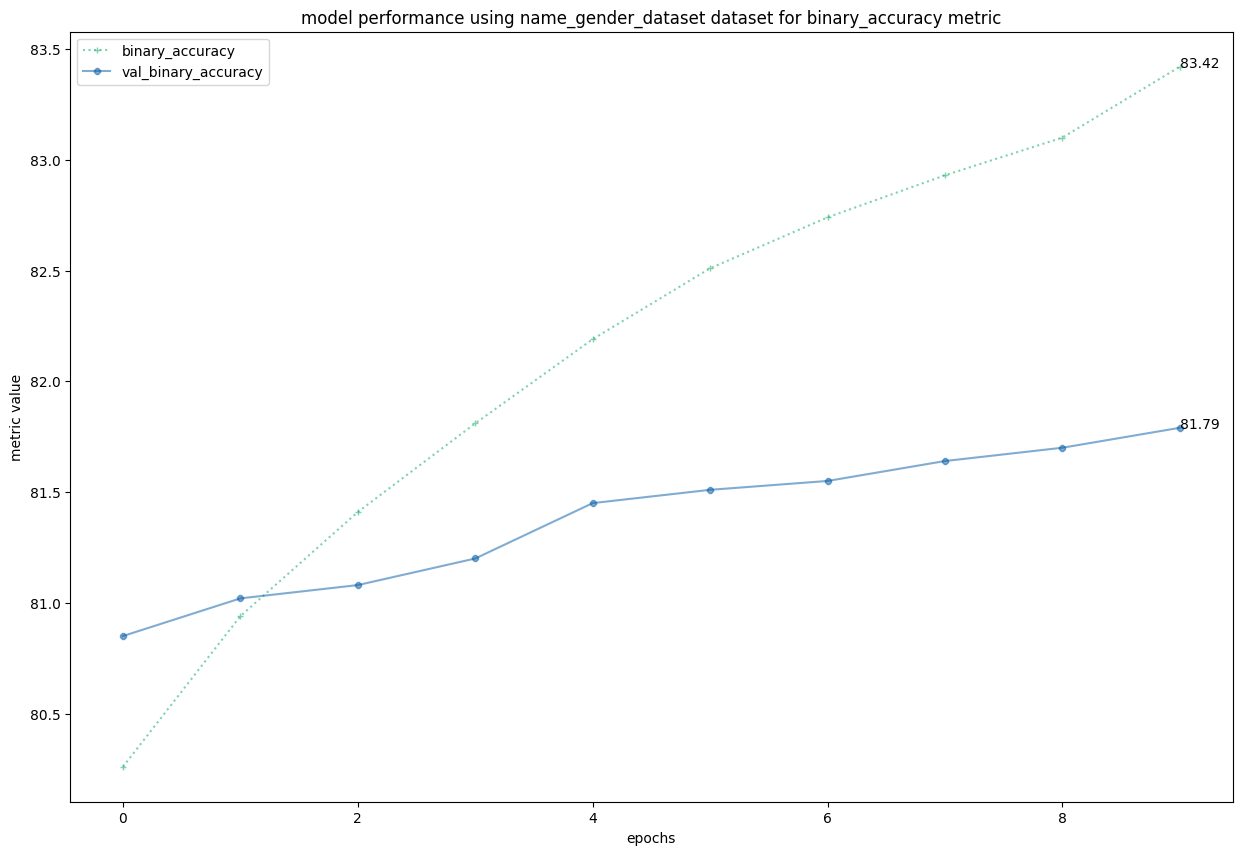

precision
val_precision
{'precision': [0.8376427888870239, 0.843586802482605, 0.8469928503036499, 0.8505743145942688, 0.8535938858985901, 0.856134295463562, 0.8578047752380371, 0.8591089248657227, 0.8606302738189697, 0.863752543926239], 'val_precision': [0.8466472625732422, 0.8409017324447632, 0.8463459610939026, 0.8285874128341675, 0.8581244945526123, 0.8563587665557861, 0.8421289324760437, 0.8424394130706787, 0.8566188812255859, 0.8526391983032227]}


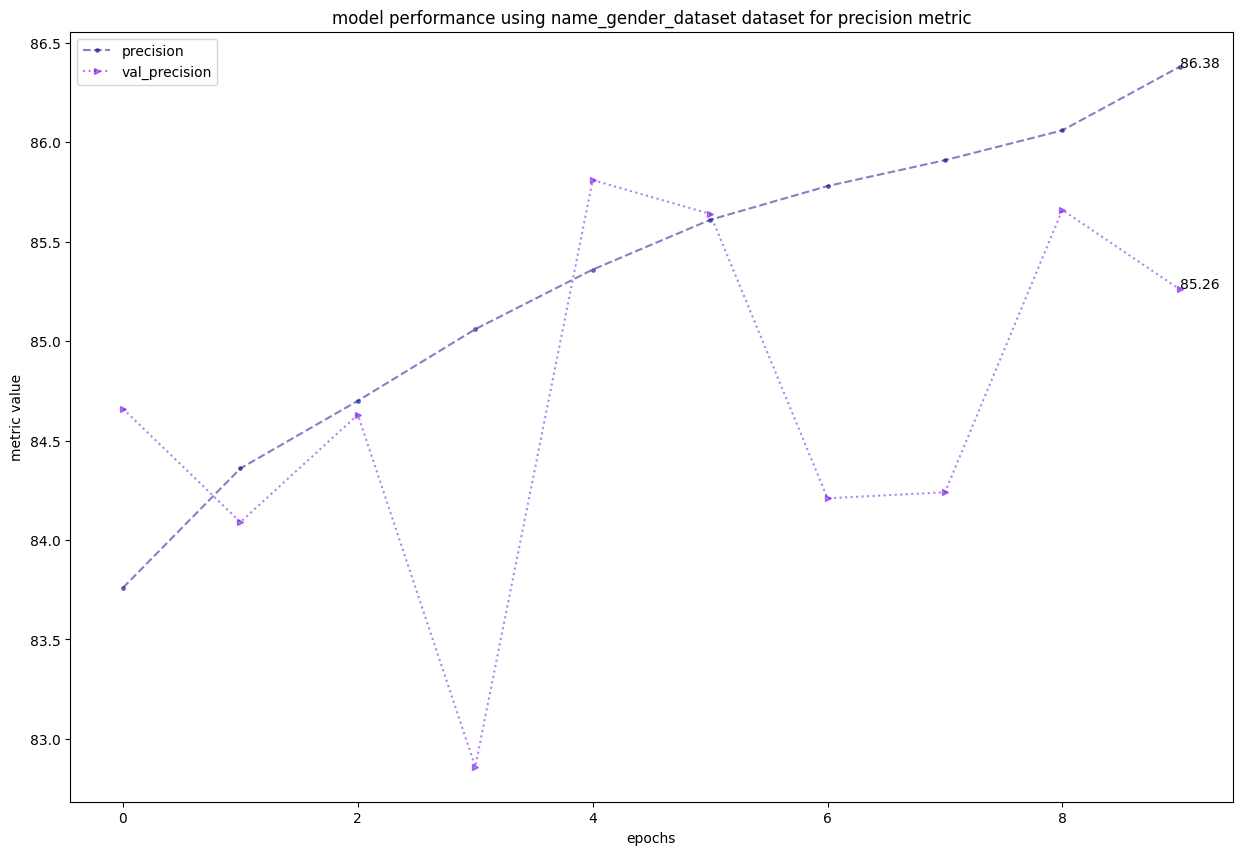

recall
val_recall
{'recall': [0.8428204655647278, 0.8478079438209534, 0.8520759344100952, 0.8548722267150879, 0.8579627871513367, 0.8606282472610474, 0.8627704381942749, 0.8646019101142883, 0.8658937215805054, 0.8675944209098816], 'val_recall': [0.8402572870254517, 0.8519393801689148, 0.8451794981956482, 0.8746472597122192, 0.8359913229942322, 0.8396666049957275, 0.8608649969100952, 0.8621776103973389, 0.8430137038230896, 0.8502329587936401]}


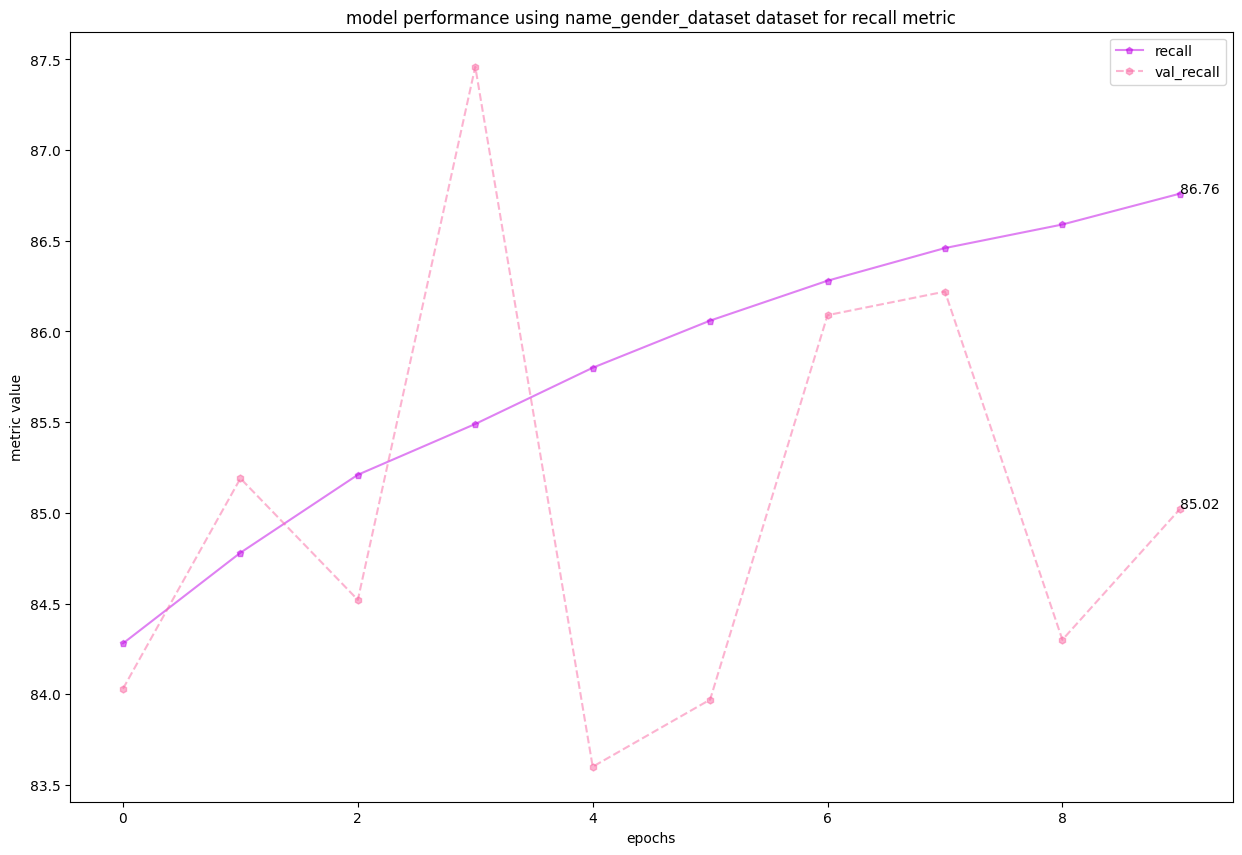

f1_score
val_f1_score
{'f1_score': [0.7623351216316223, 0.7623351216316223, 0.7623351216316223, 0.7623351216316223, 0.7623351216316223, 0.7623351216316223, 0.7623351216316223, 0.7623351216316223, 0.7623351216316223, 0.7623351216316223], 'val_f1_score': [0.7607468366622925, 0.7607468366622925, 0.7607468366622925, 0.7607468366622925, 0.7607468366622925, 0.7607468366622925, 0.7607468366622925, 0.7607468366622925, 0.7607468366622925, 0.7607468366622925]}


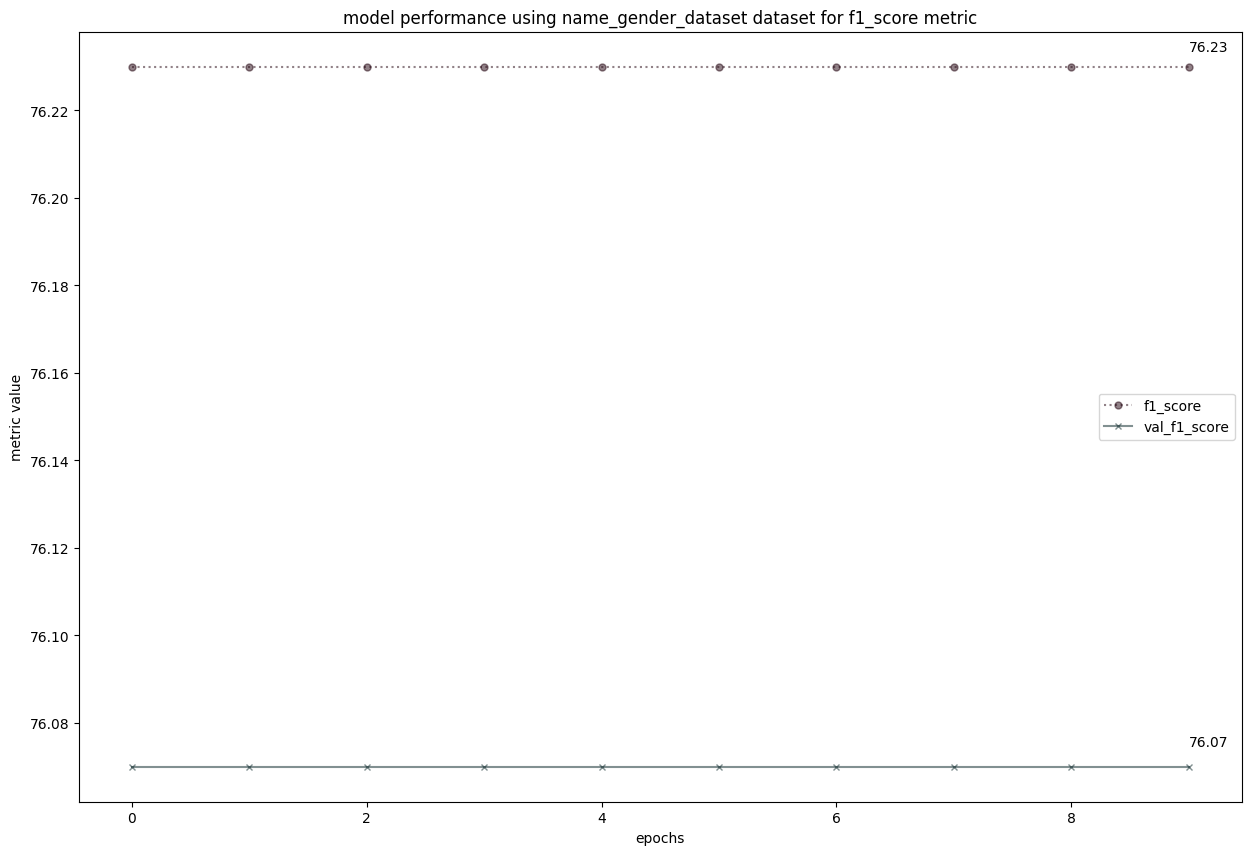

auc
val_auc
{'auc': [0.8746405243873596, 0.8812754154205322, 0.8861483931541443, 0.8905876874923706, 0.8936259746551514, 0.896675169467926, 0.8992518186569214, 0.9016092419624329, 0.9037023782730103, 0.9059439897537231], 'val_auc': [0.8802036046981812, 0.8827880620956421, 0.8844586610794067, 0.8865330219268799, 0.8883332014083862, 0.8890048861503601, 0.8888214230537415, 0.8901894688606262, 0.8909648656845093, 0.891408383846283]}


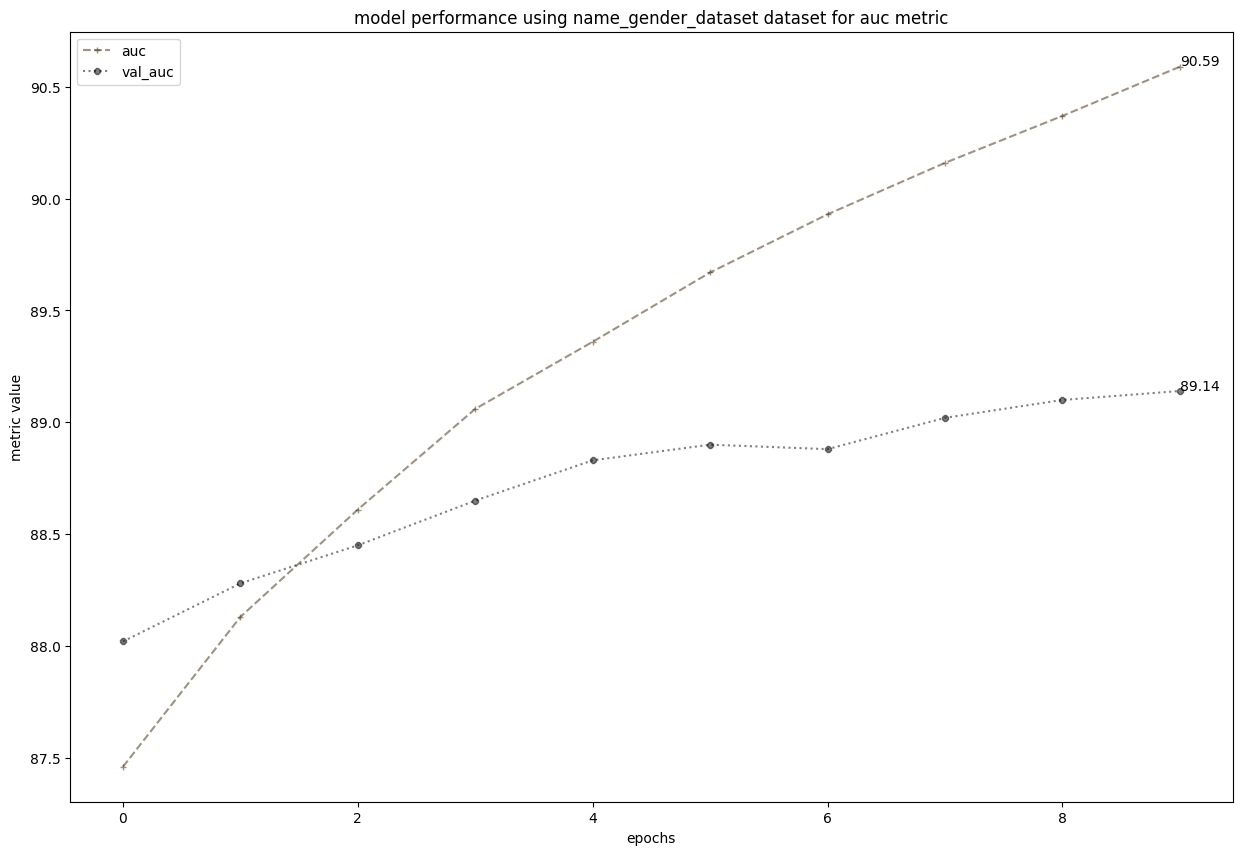

In [61]:
model_results.export_results(dataset_id="name_gender_dataset")

In [62]:
lstm_model.evaluate(test_seqs_padded, test_labels)

970/970 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.8891 - binary_accuracy: 0.8165 - binary_crossentropy: 0.4103 - f1_score: 0.7592 - loss: 0.4103 - precision: 0.8491 - recall: 0.8514


[0.40839940309524536,
 0.40839940309524536,
 0.8178302049636841,
 0.8513174653053284,
 0.8529226779937744,
 0.7618818879127502,
 0.8898484706878662]